In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../rl_network'); import actorcritic as ac;  import stategen as sg
sys.path.insert(0,'../environments/'); import gridworld_env as eu

In [2]:
## define functions
# compute confidence based on recency of memory/reward received
def make_pvals(p, envelope=15):
    return 1/np.cosh(p/envelope)

# retrieve relevant items from memory
def cosine_sim(key, dictionary, **kwargs):
    similarity_threshold = kwargs.get('threshold', 0.9)

    mem_cache = np.asarray(list(dictionary.keys()))
    entry     = np.asarray(key)

    mqt     = np.dot(mem_cache, entry)
    norm    = np.linalg.norm(mem_cache, axis = 1) * np.linalg.norm(entry) 

    cosine_similarity = mqt/norm

    index = np.argmax(cosine_similarity)
    similar_activity = mem_cache[index]
    if max(cosine_similarity) >= similarity_threshold:
        return similar_activity, index, max(cosine_similarity)

    else:
        #print('max memory similarity:', max(cosine_similarity))
        return [],[], max(cosine_similarity)
    
def make_cs(rwd, **kwargs):
    envelope = kwargs.get('envelope',10)
    tslr = []
    time_since_last_reward = np.nan 
    for i in rwd:
        tslr.append(time_since_last_reward)
        if i == 0:
            time_since_last_reward +=1
        if i == 1:
            time_since_last_reward = 0
            
    return make_pvals(np.asarray(tslr), envelope=envelope)


# make dummy list of rewards received
def make_spikelist(alpha):
    return np.random.choice([0,1], 100, p=[1-alpha,alpha])

# make dummy dictionary 
def make_dict(length, **kwargs):
    key_length = kwargs.get('key_length', 5)
    mem_length = kwargs.get('mem_length', length*10)
    d = {}
    for i in range(length):
        #make dict key
        k = tuple(np.random.choice(np.arange(10),key_length))
        num_actions = 6
        dataframe = np.empty((num_actions, 2))
        dataframe[:,0] = np.nan
        dataframe[:,1] = np.inf
        d[k] = [dataframe, -1]
        for j in range(num_actions -1):
            timestamp = np.random.randint(0, mem_length)
            deltaval = np.random.randn()
            
            d[k][0][j] = [deltaval, int(timestamp)]
            d[k][1]    = max(d[k][1], timestamp)
    return d


def softmax(x, T=1):
     """Compute softmax values for each sets of scores in x."""
     e_x = np.exp((x - np.max(x))/T)
     return e_x / e_x.sum(axis=0) # only difference
    

def plot_softmax(x, orig=False):
    for i in range(len(x)):
        y = softmax(x[i])
        if orig:
            f, axarr = plt.subplots(2, sharex=True)
            axarr[0].bar(np.arange(len(x[i])), x[i])
            axarr[1].bar(np.arange(len(x[i])), y) 
        else: 
            plt.bar(np.arange(len(x[i]))+0.1*i, y, width =0.1, alpha = 0.3)
    plt.show()

In [6]:
grid_params = {
    'y_height':   10,
    'x_width':    10,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}

#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
env = eu.gymworld(maze) # openAI-like wrapper 

agent_params = {
    'load_model':   False,
    'load_dir':     '../data/outputs/gridworld/MF{}{}training.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'action_dims':  6, #=len(maze.actionlist)
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     int(0.75*np.prod(maze.grid.shape)), # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   150,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}


#update agent params dictionary with layer sizes appropriate for environment 
agent_params = sg.gen_input(maze, agent_params)
print(agent_params['input_dims'])

MF,opt = ac.make_agent(agent_params)

EC = ec.ep_mem(MF,agent_params['cachelim']) 
print(EC.cache_limit)

(10, 10, 3)
75


In [7]:
NUM_TRIALS = 10
NUM_EVENTS = 100


add_mem_dict = {} #dictionary of items which get put into memory cache
timestamp    = 0
blocktime = time.time()

for trial in range(NUM_TRIALS):
    trialstart_stamp = timestamp

    reward_sum   = 0
    v_last       = 0

    env.reset() 

    state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
    MF.reinit_hid() #reinit recurrent hidden layers

    for event in range(NUM_EVENTS):
        # pass state through EC module
        policy_, value_, lin_act_ = MF(state)
        add_mem_dict['state'] = maze.cur_state

        '''
        NEED TO USE CONFIDENCE SCORE HERE
        - track time since last reward
        - 

        '''

        choice, policy, value = ac.select_action(MF,policy_, value_)
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)

        MF.rewards.append(reward)
        delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation

        add_mem_dict['activity']  = tuple(lin_act_.view(-1).data)
        add_mem_dict['action']    = choice
        add_mem_dict['delta']     = delta
        add_mem_dict['timestamp'] = timestamp            
        EC.add_mem(add_mem_dict)             #add event to memory cache

        # because we need to include batch size of 1 
        state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
        reward_sum += reward

        v_last = value
        timestamp += 1

    p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

    if trial ==0 or trial%1==0 or trial == NUM_TRIALS-1:
        print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
        blocktime = time.time()



[17:06:36]  Trial 1 TotRew = 0 (2.790s)
[17:06:45]  Trial 2 TotRew = 0 (9.009s)
[17:06:54]  Trial 3 TotRew = 0 (8.698s)
[17:07:03]  Trial 4 TotRew = 0 (8.885s)
[17:07:12]  Trial 5 TotRew = 0 (9.072s)
[17:07:22]  Trial 6 TotRew = 0 (10.334s)
[17:07:33]  Trial 7 TotRew = 0 (11.012s)
[17:07:43]  Trial 8 TotRew = 0 (9.159s)
[17:07:52]  Trial 9 TotRew = 0 (9.635s)
[17:08:02]  Trial 10 TotRew = 0 (10.157s)


In [ ]:
print(list(EC.cache_list.items())[0][1])

In [3]:
d = make_dict(10)
d_items = np.asarray(list(d.items()))
print(d_items)
a = [x for y, x  in d_items[:,1]]
#print(a,a.index(min(a)), d_items[a.index(min(a)),0])

test_tuple = (1,1,1,1,1)
b = cosine_sim(test_tuple, d)
print(b)

[[(2, 5, 1, 4, 9)
  list([array([[ 0.45055442, 34.        ],
       [ 0.09267329, 59.        ],
       [ 0.76902257, 14.        ],
       [ 1.24643474, 80.        ],
       [ 1.25323128, 73.        ],
       [        nan,         inf]]), 80])]
 [(7, 7, 8, 7, 1)
  list([array([[-0.41295739, 91.        ],
       [ 1.41795968, 87.        ],
       [-1.00970237, 75.        ],
       [-0.53974145, 14.        ],
       [ 0.47698501,  5.        ],
       [        nan,         inf]]), 91])]
 [(2, 5, 3, 0, 6)
  list([array([[ 8.08438726e-03,  8.80000000e+01],
       [ 2.45925917e-02,  7.60000000e+01],
       [-2.43823586e-01,  2.20000000e+01],
       [-3.69031946e-01,  1.80000000e+01],
       [-1.44327220e-01,  5.00000000e+01],
       [            nan,             inf]]), 88])]
 [(7, 5, 7, 1, 0)
  list([array([[ 1.9100403 , 90.        ],
       [ 0.12831655, 44.        ],
       [-1.31355425, 30.        ],
       [-1.06351245, 99.        ],
       [ 0.33288272, 37.        ],
       [        nan

0.7772836023119964
[91. 87. 75. 14.  5. inf] 
 [0.98401586 0.96712656 0.88681888 0.34700567 0.29259174 0.        ]
[-0.41295739  1.41795968 -1.00970237 -0.53974145  0.47698501  0.        ]
[-0.41295739  1.41795968 -1.00970237 -0.53974145  0.47698501 -0.0134913 ]


/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.


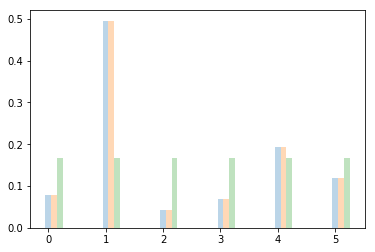

NameError: name 'try_pvals' is not defined

In [4]:
mem_, i, sim = cosine_sim(test_tuple, d, threshold = 0.5)
memory = d[tuple(mem_)]

confidence_score = sim*make_pvals(100 - memory[1], envelope=15)
print(confidence_score)

xx = np.asarray(memory)[0][:,0]
tt = np.asarray(memory)[0][:,1]
ab = np.nan_to_num(tt)
bc = 100-ab
print(tt,'\n', make_pvals(bc, envelope =50))
yy = xx.copy()



yy[5] = 0
zz = xx.copy()
zz[5] = np.average(zz[0:5])

print(yy)
print(zz)
ww = np.ones(len(xx))
plot_softmax([zz,yy, ww])




print(try_pvals(xx,15))

In [29]:
## MFC confidence score tests
import matplotlib
matplotlib.rcParams['text.usetex'] = True
## Plot showing different confidence score decay envelopes
test = np.zeros(100)
test[0]= 1

fig, ax = plt.subplots(3,1, sharex=True)
for i in range(1):
    env = i+ 15
    cs = make_cs(test,envelope=env)
    #print(i, np.where(cs<0.01)[0][0]) #how many steps before cs reaches zero
    #plt.plot(cs,label=f'{np.round(env,1)}')
    ax[0].plot(cs,label='sech(\frac{T-$t_{i}$}{$env_{E}$})')
    ax[0].plot(make_cs(test, envelope=1.5), color =(235/255,57/255,35/255), alpha=0.9, label='MF' )
#plt.legend(bbox_to_anchor = (1.25,.75))
ax[0].legend(loc='upper center', ncol=2, bbox_to_anchor = (0.5,1.15))
plt.savefig('confidence.svg', format='svg')
plt.show()
plt.close()

### plot showing decay after randomly distributed rewards
reward_frequency = 0.1
cs_envelope = 1.5

sl = make_spikelist(reward_frequency)
sl1 = np.where(sl==1)[0]

cs = make_cs(sl,envelope=cs_envelope)

plt.figure()
plt.plot(sl1, np.ones_like(sl1) ,'o', label='Reward')
plt.plot(cs,label='Confidence', color=(235/255,57/255,35/255), alpha=0.9 )
plt.legend(loc='upper center', ncol=2, bbox_to_anchor = (0.5,1.15))
plt.savefig('MF_confidence.svg', format='svg')
plt.show()
plt.close()

FileNotFoundError: [Errno 2] No such file or directory: 'dvipng': 'dvipng'

FileNotFoundError: [Errno 2] No such file or directory: 'dvipng': 'dvipng'

<Figure size 432x288 with 3 Axes>

In [ ]:
## Test dictionary for memory confidence tests
## show confidence in a dictionary entry
key_length = 10
dic_length = 50
num_sample = 1000

d = make_dict(dic_length, key_length=key_length)
pn = {}
js = [1.5/cs_envelope]
for j in js:#range(1,11):
    pn[str(j)] = [[],[],[]]
    #d = make_dict(dic_length, key_length=key_length)
    for i in range(num_sample): 
        test_key = tuple(np.random.choice(np.arange(10), key_length))
        sim_key, index = cosine_sim(test_key, d)

        if len(sim_key) is not 0:
            envelope = cs_envelope*j*10
            timestamp, deltavalue = d[tuple(sim_key)]
            confidence = make_pvals(timestamp, envelope)
            delta_scaled_conf = deltavalue*make_pvals(timestamp, envelope)
            pn[str(j)][0].append(timestamp)
            pn[str(j)][1].append(confidence)
            pn[str(j)][2].append(delta_scaled_conf)
        else:
            pass

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True)

for j in js:
    label = f'{cs_envelope*j*10}'

    #ax[0].scatter(pn[str(j)][0], pn[str(j)][1], label=label)
    #ax[1].scatter(pn[str(j)][0], pn[str(j)][2], label=label)
    
    # plot time-dependent confidence
    test = zip(pn[str(j)][0], pn[str(j)][1])
    sort_test = sorted(test, key = lambda x: x[0])
    ax[0].plot(np.array(sort_test)[:,0], np.array(sort_test)[:,1], label=label)
    
    # plot delta-scaled confidence
    test = zip(pn[str(j)][0], pn[str(j)][2])
    sort_test = sorted(test, key = lambda x: x[0])
    ax[1].plot(np.array(sort_test)[:,0], np.array(sort_test)[:,1], label=label)
    
    
ax[0].legend(loc='upper center', bbox_to_anchor=(.5,1.3), ncol =3)
plt.show()
plt.close()

In [ ]:
a = np.empty((6,2))
a[:,0] = np.nan
a[:,1] = 0 
a[2] = [10, 2]
a[4] = [1, -4]
print(a)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
x = make_pvals(a[:,0], 15)

print(np.arange(len(x)))

plt.figure()
plt.scatter(np.arange(len(x)), x)
plt.scatter(np.arange(len(x)), np.multiply(x, sigmoid(a[:,1])))

In [ ]:
# need to create arbitrator to decide between confidence of MFC and EC
''' 
option 1: softmax MF_cs and EC_cs 
    use this as a probability distribution to select either MF or EC

# pros:
 don't have to worry about convex combinations in nonconvex spaces 
# cons:
    20% certainty is not good, you want to heavily favour 80% confidence? 

option 2: combine pi_mf and pi_ec weighted by their respective cs scores
# pros:

# cons: 
'''


In [30]:
a = np.array((235,57,35))
print(a/255)

[0.92156863 0.22352941 0.1372549 ]


In [ ]:
## test how long a cosine similarity calculation takes for different key lengths
num_runs = 40
key_length = 100 # len(list(d.keys())[0])
d = make_dict(50, key_length = key_length)
avg_h = 0
for i in range(num_runs):
    test_key = tuple(np.random.choice(np.arange(10), key_length))
    start_time = time.time()
    cosine_sim(test_key, d)
    avg_h += time.time()-start_time
print(f'average run time is {avg_h/num_runs}')